## Load the data & basic integrity checks

In [1]:
import pandas as pd

df = pd.read_csv('bns_sections.csv')

df.sample(5)

,Chapter,Chapter_name,Chapter_subtype,Section,Section _name,Description
149,7,OF OFFENCES AGAINST THE STATE,OF OFFENCES AGAINST THE STATE,150,Concealing with intent to facilitate design to...,"Whoever by any act, or by any illegal omission..."
148,7,OF OFFENCES AGAINST THE STATE,OF OFFENCES AGAINST THE STATE,149,"Collecting arms, etc., with intention of wagin...","Whoever collects men, arms or ammunition or ot..."
198,12,OF OFFENCES BY OR RELATING TO PUBLIC SERVANTS,OF OFFENCES BY OR RELATING TO PUBLIC SERVANTS,199,Public servant disobeying direction under law,"Whoever, being a public servant,—\r\n(a) knowi..."
206,13,OF CONTEMPTS OF THE LAWFUL AUTHORITY OF PUBLIC...,OF CONTEMPTS OF THE LAWFUL AUTHORITY OF PUBLIC...,207,Preventing service of summons or other proceed...,Whoever in any manner intentionally prevents t...
342,18,OF OFFENCES RELATING TO DOCUMENTS AND TO PROPE...,OF OFFENCES RELATING TO DOCUMENTS AND TO PROPE...,343,"Fraudulent cancellation, destruction, etc., of...","Whoever fraudulently or dishonestly, or with i..."


In [2]:
df.shape

(358, 6)

In [3]:
df.columns.tolist()

['Chapter',
 'Chapter_name',
 'Chapter_subtype',
 'Section',
 'Section _name',
 'Description']

In [4]:
df.isnull().sum()

Chapter            0
Chapter_name       0
Chapter_subtype    0
Section            0
Section _name      0
Description        0
dtype: int64

In [5]:
df = df.rename({'Section _name': 'Section_name'}, axis=1)
df.columns

Index(['Chapter', 'Chapter_name', 'Chapter_subtype', 'Section', 'Section_name',
       'Description'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Chapter          358 non-null    int64 
 1   Chapter_name     358 non-null    object
 2   Chapter_subtype  358 non-null    object
 3   Section          358 non-null    int64 
 4   Section_name     358 non-null    object
 5   Description      358 non-null    object
dtypes: int64(2), object(4)
memory usage: 16.9+ KB


## Data integrity: duplicates & unique counts

In [7]:
# duplicates
print("Full row duplicates:", df.duplicated().sum())
print("Duplicates on (Section, Description):",
      df.duplicated(subset=['Section', 'Description']).sum())

# unique counts
print("Unique chapters:", df['Chapter'].nunique())
print("Unique chapter names:", df['Chapter_name'].nunique())
print("Unique sections:", df['Section'].nunique())

Full row duplicates: 0
Duplicates on (Section, Description): 0
Unique chapters: 20
Unique chapter names: 24
Unique sections: 358


## Text-length / distribution stats

In [8]:
df['desc_len_chars'] = df['Description'].fillna("").str.len()
df['desc_len_words'] = df['Description'].fillna("").str.split().str.len()

print(df['desc_len_chars'].describe())
print(df['desc_len_words'].describe())

count      358.000000
mean       956.446927
std       1230.919081
min         71.000000
25%        353.250000
50%        555.500000
75%       1077.000000
max      12844.000000
Name: desc_len_chars, dtype: float64
count     358.000000
mean      167.729050
std       216.878277
min        15.000000
25%        61.250000
50%        98.000000
75%       187.750000
max      2199.000000
Name: desc_len_words, dtype: float64


In [9]:
# Example: top 10 longest sections
df.sort_values('desc_len_words', ascending=False).head(
    10)[['Chapter', 'Section', 'Section_name', 'desc_len_words']]

,Chapter,Section,Section_name,desc_len_words
1,1,2,Definitions.,2199
355,19,356,Defamation,1543
334,18,335,Making a false document.,1318
100,6,101,Murder.,1177
302,17,303,Theft,1104
2,1,3,General explanations,857
315,17,316,Criminal breach of trust.,856
112,6,113,Terrorist act.,786
45,4,46,Abettor.,747
313,17,314,Dishonest misappropriation of property.,734


## Class distribution (sections per chapter)

In [10]:
counts = df.groupby(['Chapter', 'Chapter_name'])[
    'Section'].nunique().reset_index(name='sections_count')
counts = counts.sort_values('sections_count', ascending=False)
counts.head(20)
# plot if you want

,Chapter,Chapter_name,sections_count
6,6,OF OFFENCES AFFECTING THE HUMAN BODY,47
14,14,OF FALSE EVIDENCE AND OFFENCES AGAINST PUBLIC ...,43
5,5,OF OFFENCES AGAINST WOMAN AND CHILD,37
17,17,OF OFFENCES AGAINST PROPERTY,32
15,15,"OF OFFENCES AFFECTING THE PUBLIC HEALTH, SAFET...",28
13,13,OF CONTEMPTS OF THE LAWFUL AUTHORITY OF PUBLIC...,21
2,3,General exceptions,20
4,4,"OF ABETMENT, CRIMINAL CONSPIRACY AND ATTEMPT",18
7,7,OF OFFENCES AGAINST THE STATE,12
10,10,"OF OFFENCES RELATING TO COIN, CURRENCY-NOTES, ...",11


## Top tokens / n-grams (quick look)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = df['Description'].fillna("").astype(str)

vect = CountVectorizer(stop_words='english',
                       ngram_range=(1, 1), max_features=5000)
X = vect.fit_transform(corpus)
freq = X.sum(axis=0).A1
top_idx = freq.argsort()[::-1][:30]
top_words = [(vect.get_feature_names_out()[i], freq[i]) for i in top_idx]
top_words

[('shall', np.int64(838)),
 ('person', np.int64(688)),
 ('imprisonment', np.int64(615)),
 ('extend', np.int64(510)),
 ('fine', np.int64(469)),
 ('term', np.int64(438)),
 ('punished', np.int64(431)),
 ('offence', np.int64(422)),
 ('years', np.int64(380)),
 ('description', np.int64(321)),
 ('section', np.int64(283)),
 ('liable', np.int64(253)),
 ('act', np.int64(228)),
 ('public', np.int64(218)),
 ('cause', np.int64(218)),
 ('committed', np.int64(203)),
 ('death', np.int64(198)),
 ('property', np.int64(193)),
 ('likely', np.int64(151)),
 ('servant', np.int64(149)),
 ('life', np.int64(148)),
 ('commits', np.int64(137)),
 ('knowing', np.int64(135)),
 ('explanation', np.int64(121)),
 ('causes', np.int64(121)),
 ('hurt', np.int64(114)),
 ('rupees', np.int64(112)),
 ('law', np.int64(106)),
 ('means', np.int64(104)),
 ('intending', np.int64(101))]

## Legal-specific checks (regex + NER ideas)

In [12]:
import re
pattern = re.compile(r'\bSection\s*\d+|\d+\([a-z0-9]+\)')
df['has_crossref'] = df['Description'].astype(
    str).apply(lambda t: bool(pattern.search(t)))
print(df['has_crossref'].sum(), "sections mention other sections")

0 sections mention other sections


## Sampling for manual review

In [13]:
# stratified sample: one section per chapter (if chapters many, sample n)
sample = df.groupby('Chapter').apply(lambda d: d.sample(
    n=1, random_state=42)).reset_index(drop=True)
sample.head()

/tmp/ipykernel_762/3510399937.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = df.groupby('Chapter').apply(lambda d: d.sample(


,Chapter,Chapter_name,Chapter_subtype,Section,Section_name,Description,desc_len_chars,desc_len_words,has_crossref
0,1,Preliminary,Preliminary,1,"Short title, commencement and application",(1) This Act may be called the Bharatiya Nyaya...,1680,290,False
1,2,Of punishments,Of punishments,12,Limit of solitary confinement.,In executing a sentence of solitary confinemen...,480,75,False
2,3,Of right of private defence,Of right of private defence,41,When right of private defence of property exte...,The right of private defence of property exten...,830,135,False
3,4,"OF ABETMENT, CRIMINAL CONSPIRACY AND ATTEMPT",of abetment,45,Abetment of a thing.,"A person abets the doing of a thing, who—\r\n(...",1171,212,False
4,5,OF OFFENCES AGAINST WOMAN AND CHILD,Of offences relating to marriage,80,Dowry death.,(1) Where the death of a woman is caused by an...,773,136,False


In [14]:
# sample.to_csv('bns_sample_one_per_chapter.csv', index=False)

## Chapter Distribution Plot

/tmp/ipykernel_762/1410910483.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


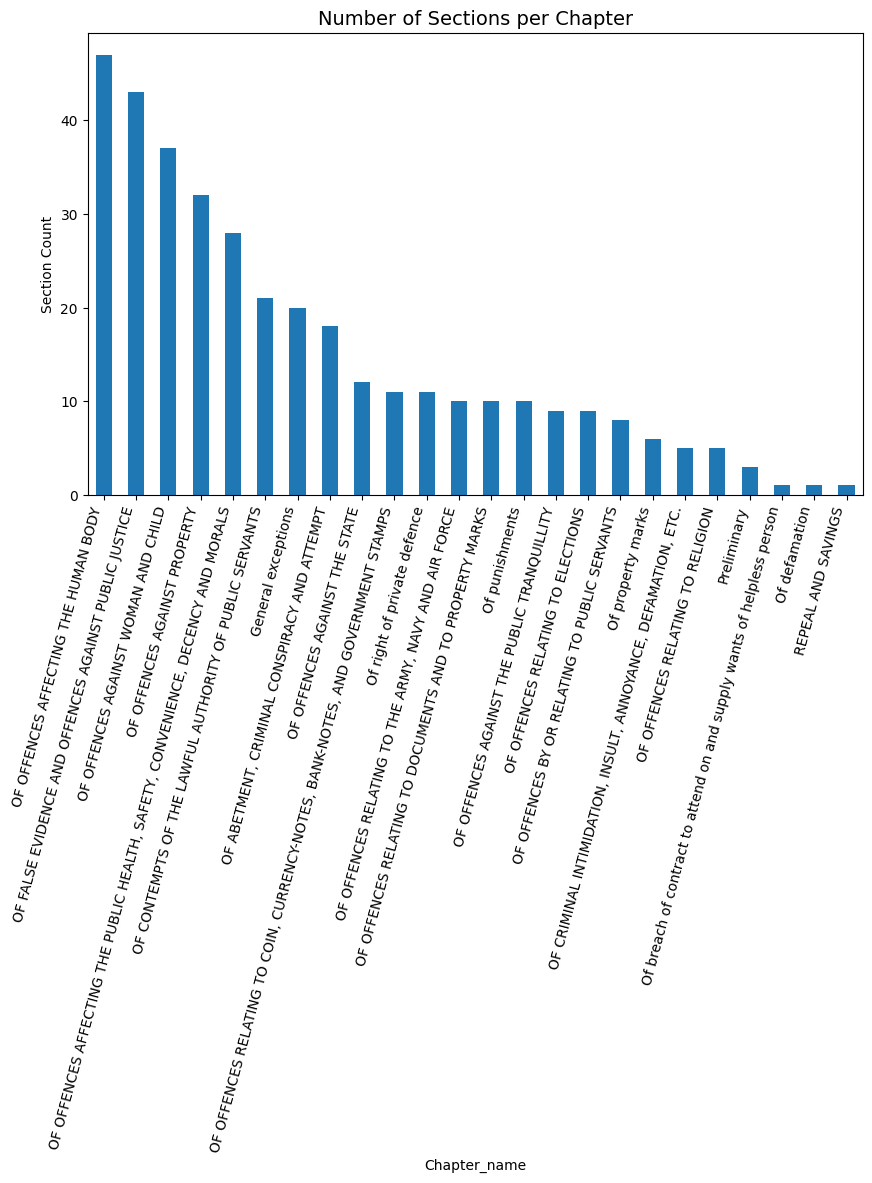

In [15]:
import matplotlib.pyplot as plt

# Count sections per chapter
chapter_counts = df.groupby('Chapter_name')[
    'Section'].count().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
chapter_counts.plot(kind='bar')
plt.title("Number of Sections per Chapter", fontsize=14)
plt.ylabel("Section Count")
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
df.groupby('Chapter_name')[
    'Section'].count().sort_values(ascending=False)

Chapter_name
OF OFFENCES AFFECTING THE HUMAN BODY                                                47
OF FALSE EVIDENCE AND OFFENCES AGAINST PUBLIC JUSTICE                               43
OF OFFENCES AGAINST WOMAN AND CHILD                                                 37
OF OFFENCES AGAINST PROPERTY                                                        32
OF OFFENCES AFFECTING THE PUBLIC HEALTH, SAFETY, CONVENIENCE, DECENCY AND MORALS    28
OF CONTEMPTS OF THE LAWFUL AUTHORITY OF PUBLIC SERVANTS                             21
General exceptions                                                                  20
OF ABETMENT, CRIMINAL CONSPIRACY AND ATTEMPT                                        18
OF OFFENCES AGAINST THE STATE                                                       12
OF OFFENCES RELATING TO COIN, CURRENCY-NOTES, BANK-NOTES, AND GOVERNMENT STAMPS     11
Of right of private defence                                                         11
OF OFFENCES RELATING TO THE AR

## Chapter vs. Chapter_subtype

In [16]:
subtype_map = df[['Chapter', 'Chapter_name',
                  'Chapter_subtype']].drop_duplicates()
subtype_map = subtype_map.sort_values(['Chapter', 'Chapter_subtype'])

print(subtype_map.to_string(index=False))

 Chapter                                                                     Chapter_name                                                                  Chapter_subtype
       1                                                                      Preliminary                                                                      Preliminary
       2                                                                   Of punishments                                                                   Of punishments
       3                                                               General exceptions                                                               General exceptions
       3                                                      Of right of private defence                                                      Of right of private defence
       4                                     OF ABETMENT, CRIMINAL CONSPIRACY AND ATTEMPT                                                        

## Class Imbalance Severity

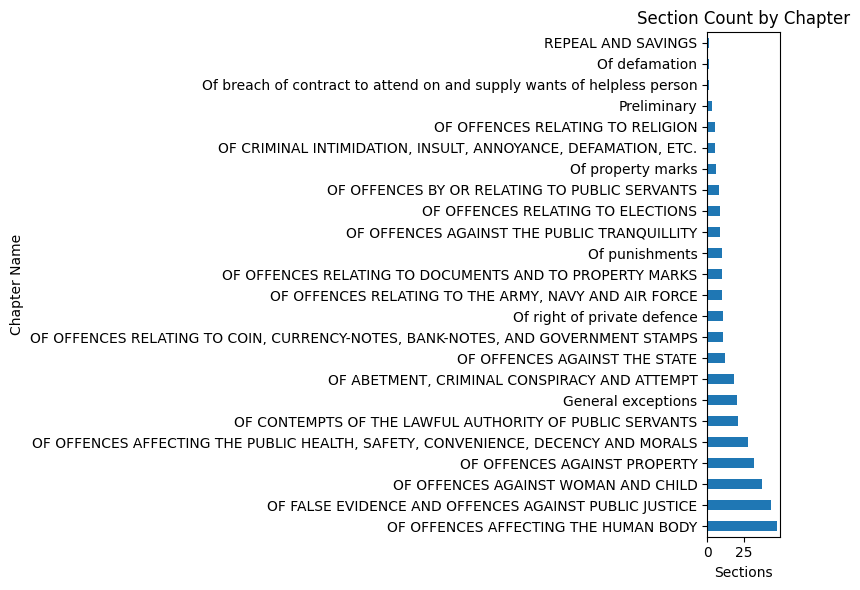

Imbalance ratio (max/min): 47.00


In [17]:
chapter_counts.plot(kind='barh', figsize=(8,6))
plt.title("Section Count by Chapter")
plt.xlabel("Sections")
plt.ylabel("Chapter Name")
plt.tight_layout()
plt.show()

imbalance_ratio = chapter_counts.max() / chapter_counts.min()
print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")


In [19]:
chapter_counts = df['Chapter_name'].value_counts()
rare_chapters = chapter_counts[chapter_counts < 5].index.tolist()
df['Chapter_grouped'] = df['Chapter_name'].apply(
    lambda x: x if x not in rare_chapters else 'Other')

In [20]:
df.head()

,Chapter,Chapter_name,Chapter_subtype,Section,Section_name,Description,desc_len_chars,desc_len_words,has_crossref,Chapter_grouped
0,1,Preliminary,Preliminary,1,"Short title, commencement and application",(1) This Act may be called the Bharatiya Nyaya...,1680,290,False,Other
1,1,Preliminary,Preliminary,2,Definitions.,"In this Sanhita, unless the context otherwise ...",12844,2199,False,Other
2,1,Preliminary,Preliminary,3,General explanations,(1) Throughout this Sanhita every definition o...,4793,857,False,Other
3,2,Of punishments,Of punishments,4,Punishments,The punishments to which offenders are liable ...,304,46,False,Of punishments
4,2,Of punishments,Of punishments,5,Commutation of sentence,"The appropriate Government may, without the co...",740,122,False,Of punishments


In [21]:
df.groupby('Chapter_name')[
    'Section'].count().sort_values(ascending=False)

Chapter_name
OF OFFENCES AFFECTING THE HUMAN BODY                                                47
OF FALSE EVIDENCE AND OFFENCES AGAINST PUBLIC JUSTICE                               43
OF OFFENCES AGAINST WOMAN AND CHILD                                                 37
OF OFFENCES AGAINST PROPERTY                                                        32
OF OFFENCES AFFECTING THE PUBLIC HEALTH, SAFETY, CONVENIENCE, DECENCY AND MORALS    28
OF CONTEMPTS OF THE LAWFUL AUTHORITY OF PUBLIC SERVANTS                             21
General exceptions                                                                  20
OF ABETMENT, CRIMINAL CONSPIRACY AND ATTEMPT                                        18
OF OFFENCES AGAINST THE STATE                                                       12
OF OFFENCES RELATING TO COIN, CURRENCY-NOTES, BANK-NOTES, AND GOVERNMENT STAMPS     11
Of right of private defence                                                         11
OF OFFENCES RELATING TO THE AR

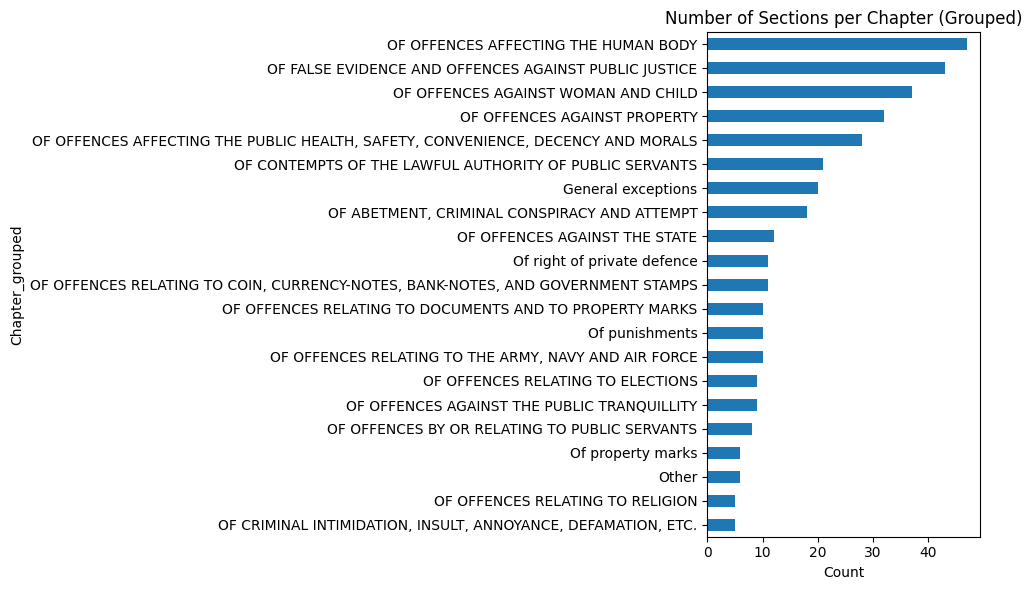

In [22]:
import matplotlib.pyplot as plt

df['Chapter_grouped'].value_counts().sort_values().plot(
    kind='barh', figsize=(10, 6))
plt.title("Number of Sections per Chapter (Grouped)")
plt.xlabel("Count")
plt.tight_layout()
plt.show()

In [24]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'section\s*\d+[a-zA-Z()]*', '', text)  # remove 'section xx'
    text = re.sub(r'\d+', '', text)  # remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)


[nltk_data] Downloading package stopwords to /home/vasant/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/vasant/nltk_data...


In [25]:
df['clean_text'] = df['Description'].astype(str).apply(clean_text)
df['clean_text']

0      act may called bharatiya nyaya sanhita shall c...
1      sanhita unless context otherwise requires–– “a...
2      throughout sanhita every definition offence ev...
3      punishment offender liable provision sanhita a...
4      appropriate government may without consent off...
                             ...                        
353    whoever voluntarily cause attempt cause person...
354    whoever state intoxication appears public plac...
355    whoever word either spoken intended read sign ...
356    whoever bound lawful contract attend supply wa...
357    indian penal code hereby repealed notwithstand...
Name: clean_text, Length: 358, dtype: object

In [26]:
df['raw_text'] = df['Description']
df['clean_text'] = df['Description'].astype(str).apply(clean_text)

## Option 1: TF-IDF (Baseline & interpretable)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    ngram_range=(1,2)  # include unigrams and bigrams
)

X_tfidf = tfidf.fit_transform(df['clean_text'])
print(X_tfidf.shape)  # (358, 5000) e.g.


(358, 5000)


## Option 2: Sentence Embeddings (For semantic similarity / classification)

In [27]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')  # small and fast
X_embed = model.encode(df['Description'].tolist(), show_progress_bar=True)

/home/vasant/projects/Bharatiya-Nyaya-Sanhita/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 12/12 [00:14<00:00,  1.22s/it]


## Option 3: BERT Tokenization (for deep model inputs)

In [28]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokens = tokenizer(
    df['Description'].tolist(),
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

## Modeling (Baseline with TF-IDF + Logistic Regression)

### 1. Prepare Labels

In [37]:
df['Chapter_grouped'].unique()

array(['Other', 'Of punishments', 'General exceptions',
       'Of right of private defence',
       'OF ABETMENT, CRIMINAL CONSPIRACY AND ATTEMPT',
       'OF OFFENCES AGAINST WOMAN AND CHILD',
       'OF OFFENCES AFFECTING THE HUMAN BODY',
       'OF OFFENCES AGAINST THE STATE',
       'OF OFFENCES RELATING TO THE ARMY, NAVY AND AIR FORCE',
       'OF OFFENCES RELATING TO ELECTIONS',
       'OF OFFENCES RELATING TO COIN, CURRENCY-NOTES, BANK-NOTES, AND GOVERNMENT STAMPS',
       'OF OFFENCES AGAINST THE PUBLIC TRANQUILLITY',
       'OF OFFENCES BY OR RELATING TO PUBLIC SERVANTS',
       'OF CONTEMPTS OF THE LAWFUL AUTHORITY OF PUBLIC SERVANTS',
       'OF FALSE EVIDENCE AND OFFENCES AGAINST PUBLIC JUSTICE',
       'OF OFFENCES AFFECTING THE PUBLIC HEALTH, SAFETY, CONVENIENCE, DECENCY AND MORALS',
       'OF OFFENCES RELATING TO RELIGION', 'OF OFFENCES AGAINST PROPERTY',
       'OF OFFENCES RELATING TO DOCUMENTS AND TO PROPERTY MARKS',
       'Of property marks',
       'OF CRIMINAL I

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['Chapter_grouped'])

# Split TF-IDF features and labels
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

### 2. Train a Logistic Regression Model

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

### 3. Evaluate

In [32]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Classification Report:
                                                                                  precision    recall  f1-score   support

                                                              General exceptions       0.80      1.00      0.89         4
                                    OF ABETMENT, CRIMINAL CONSPIRACY AND ATTEMPT       1.00      1.00      1.00         4
                         OF CONTEMPTS OF THE LAWFUL AUTHORITY OF PUBLIC SERVANTS       0.50      0.50      0.50         4
                   OF CRIMINAL INTIMIDATION, INSULT, ANNOYANCE, DEFAMATION, ETC.       0.00      0.00      0.00         1
                           OF FALSE EVIDENCE AND OFFENCES AGAINST PUBLIC JUSTICE       0.80      0.89      0.84         9
                                            OF OFFENCES AFFECTING THE HUMAN BODY       0.71      0.50      0.59        10
OF OFFENCES AFFECTING THE PUBLIC HEALTH, SAFETY, CONVENIENCE, DECENCY AND MORALS       0.86      1.00      0.92         6


/home/vasant/projects/Bharatiya-Nyaya-Sanhita/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vasant/projects/Bharatiya-Nyaya-Sanhita/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vasant/projects/Bharatiya-Nyaya-Sanhita/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

In [34]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(12, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.xticks(rotation=45)
# plt.yticks(rotation=45)
# plt.tight_layout()
# plt.show()